In this lab you will do the following steps in order:

1. Load a new dataset using ``torchvision dataloader``
2. Perform transfer learning of a pre-trained NN (Neural Network)





Useful resources:

* [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)






Use GPU if available

In [1]:
import torch

device = torch.device("cuda") # mps or cpu, gpu if colab

Data preparation

In [2]:

#download images       exlamation mark means commandline, not really python
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
#download metadata
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
#extract
!tar -xf imdb_crop.tar
!tar -xf imdb_meta.tar


# Didn't work (on local)! alternative:

'''
import urllib.request
urllib.request.urlretrieve("https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar", "imdb_crop.tar")
urllib.request.urlretrieve("https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar", "imdb_meta.tar")
'''

--2024-04-29 13:39:56--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  16.6MB/s    in 8m 23s  

2024-04-29 13:48:20 (13.3 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]

--2024-04-29 13:48:20--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22937600 (22M) [application/x-tar]
Saving to: ‘imdb_meta.tar’

imdb_meta

'\nimport urllib.request\nurllib.request.urlretrieve("https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar", "imdb_crop.tar")\nurllib.request.urlretrieve("https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar", "imdb_meta.tar")\n'

Remove grayscale images

In [3]:
import glob  # Import library for finding all files matching a pattern
from PIL import Image  # Import library for image processing
import numpy as np  # Import library for numerical operations (not used here)
import os  # Import library for operating system functionalities

# Define a path pattern to search for all jpg images within subdirectories of "/content/imdb_crop"
image_path_pattern = "imdb_crop/*/*.jpg"

# Find all image file paths matching the pattern
image_paths = glob.glob(image_path_pattern)


# Only first run: removes not-RGB images

# Iterate through each image path
for image_path in image_paths:
  # Open the image using Pillow's Image class
  image = Image.open(image_path)

  # Get the number of color channels in the image (e.g., RGB has 3 channels)
  num_channels = len(image.getbands())

  # Check if the image has a different number of channels than expected (likely grayscale or unsupported format)
  if num_channels != 3:
    # If not 3 channels, remove the image file
    os.remove(image_path)
    #print(f"Removed {image_path} (not RGB format)")  # Print statement to show removed files

Define function to convert numeric date to common date format

In [6]:
from datetime import datetime, timedelta  # Import libraries for date and time manipulation

def datenum_to_datetime(datenum):

  try:
    # Extract components from the datenum
    days = datenum % 1  # Extract days (decimal part)
    hours = days % 1 * 24  # Extract hours from remaining decimal part
    minutes = hours % 1 * 60  # Extract minutes from remaining decimal part
    seconds = minutes % 1 * 60  # Extract seconds from remaining decimal part

    # Convert to datetime object with separate day, hour, minute, and second components
    exact_date = (datetime.fromordinal(int(datenum))  # Convert integer part to date
                 + timedelta(days=int(days))  # Add extracted days
                 + timedelta(hours=int(hours))  # Add extracted hours
                 + timedelta(minutes=int(minutes))  # Add extracted minutes
                 + timedelta(seconds=round(seconds)))  # Add extracted seconds (rounded)

    # Adjust for Excel's epoch being different from standard epoch (correct for year)
    exact_date -= timedelta(days=366)

    # Return the year from the converted datetime object
    return exact_date.year

  except (ValueError, TypeError, OverflowError) as e:
    return np.nan  # Return np.nan if conversion fails


Define the [dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy
import torch
import collections

class FacesDataset(Dataset):

      def __init__(self, root_dir, transform, split):

        self.split=split
        self.root_dir = root_dir
        self.data = self.get_data()  # Load and preprocess data
        total_data_len = int(len(self.data) * 0.5)  # Select small portion of the dataset
        #

        # Randomly shuffle indices for train/val/test split
        idx = np.arange(total_data_len)
        np.random.seed(0)
        np.random.shuffle(idx)
        print(f"Shuffled indices (first 5): {idx[:5]}")  # Print first 5 shuffled indices

        # Select data based on split 
        if split == "train":
            self.data = self.data[idx[:int(total_data_len * 0.6)]]
        elif split == "val":
            self.data = self.data[idx[int(total_data_len * 0.6):int(total_data_len * 0.8)]]
        else:
            self.data = self.data[idx[int(total_data_len * 0.8):]]

        # Analyze age distribution (uncomment to print)
        #age_distribution = collections.Counter()
        #for i, sample in enumerate(self.data):
        #age_distribution[sample[1]] += 1
        #print(age_distribution)  # Uncomment to print the Counter object

        self.transform = transform



      def get_data(self):


        # Load data from MAT file and define column names
        mat_imdb = scipy.io.loadmat('imdb/imdb.mat')
        columns = ["full_path", "dob", "photo_taken", "second_face_score", "face_score"]

        # Convert loaded data into a dictionary, requires quite investigation to find the right indexes
        data_dict = {col: mat_imdb['imdb'][0][0][col][0] for col in columns}

        # Create pandas DataFrame for efficient data manipulation
        df_imdb = pd.DataFrame(data_dict)
        if self.split=="train":
          print("Before processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        # Convert date of birth to age using vectorized operations
        df_imdb['date_of_birth'] = df_imdb['dob'].apply(datenum_to_datetime)
        df_imdb['age'] = df_imdb['photo_taken'].sub(df_imdb['date_of_birth'])  # Handle potential NaNs

        # Filter images based on face score and presence of a single face
        df_imdb = df_imdb[df_imdb['face_score'] != -np.inf]  # Remove images without a face
        df_imdb = df_imdb[df_imdb['second_face_score'].isna()]  # Ensure only one face is present
        df_imdb = df_imdb[df_imdb['face_score'] >= 3.5]  # Filter based on minimum face score threshold
        df_imdb = df_imdb[(df_imdb['age'] <= 100) & (df_imdb['age'] >= 0)]  # Filter for valid age range
        df_imdb['age'] = df_imdb['age'].apply(lambda x: int(x))  # Convert age to integer
        df_imdb = df_imdb.drop(columns=['date_of_birth', 'dob', 'photo_taken', "second_face_score", "face_score"])  # Remove unnecessary columns

        # Construct full image paths using vectorized operations
        df_imdb['full_path'] = self.root_dir+"/"+ df_imdb['full_path'].apply(lambda x: x[0])

        # Filter for images with existing paths using vectorized boolean indexing
        df_imdb = df_imdb[df_imdb['full_path'].apply(os.path.exists)]

        if self.split=="train":
          print("After processing:")
          print(df_imdb.shape)  # Print DataFrame shape
          print(df_imdb.head())  # Print the first few rows

        return df_imdb.to_numpy()  # Return preprocessed data as a NumPy array

      def __len__(self):

        return len(self.data)

      def __getitem__(self, idx):

        img_name, age = self.data[idx]
        image = Image.open(os.path.join(self.root_dir, img_name[10:]))    
        image = self.transform(image)                                    
        age = age / 100

        sample = {'image': image, 'age': torch.tensor(age).float()}
        return sample

Build the train/val/test dataloaders


In [11]:
import pickle

# Define data transformations (augmentations for training and normalization) be careful about good practice
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally for training augmentation
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values based on ImageNet statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (consistent with training)
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize(  # Normalize pixel values using the same statistics
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set batch size
bs = 32

# Create datasets for training, validation, and testing
print("Train set:")
trainset = FacesDataset("imdb_crop", transform_train, split="train")
print("Validation set:")
valset = FacesDataset("imdb_crop", transform_val, split="val")
print("Test set:")
testset = FacesDataset("imdb_crop", transform_val, split="test")

# Create data loaders for efficient batch training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Print dataset and dataloader lengths (number of samples and batches)
print(f"Number of training samples: {len(trainloader) * bs}")
print(f"Number of validation samples: {len(valloader)}")
print(f"Number of test samples: {len(testloader)}")


Train set:
Before processing:
(460723, 5)
                                        full_path     dob  photo_taken  \
0   [01/nm0000001_rm124825600_1899-5-10_1968.jpg]  693726         1968   
1  [01/nm0000001_rm3343756032_1899-5-10_1970.jpg]  693726         1970   
2   [01/nm0000001_rm577153792_1899-5-10_1968.jpg]  693726         1968   
3   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]  693726         1968   
4   [01/nm0000001_rm980463616_1899-5-10_1968.jpg]  693726         1968   

   second_face_score  face_score  
0           1.118973    1.459693  
1           1.852008    2.543198  
2           2.985660    3.455579  
3                NaN    1.872117  
4                NaN    1.158766  
After processing:
(71828, 2)
                                            full_path  age
7   imdb_crop/02/nm0000002_rm1363385088_1924-9-16_...   80
15  imdb_crop/02/nm0000002_rm2585828096_1924-9-16_...   82
18  imdb_crop/02/nm0000002_rm2769394176_1924-9-16_...   82
19  imdb_crop/02/nm0000002_rm278040371

2. Define a Neural Network (NN) [Mobilenet](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2) pretrained on Imagenet.

Replace the last classifier

In [14]:
import torchvision
import torch.nn as nn

# Define the model architecture (MobileNetV2)
#net = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')  # Load pre-trained weights

net = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')

# https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b3.html#torchvision.models.EfficientNet_B3_Weights

# Adjust the final classification layer
num_ftrs = net.classifier[1].in_features  # Get the number of input features for the last layer
net.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First linear layer with 512 units
    nn.GELU(),  # GELU activation function
    nn.Linear(512, 32),  # Second linear layer with 32 units
    nn.GELU(),  # GELU activation function
    nn.Linear(32, 1)   # Output layer with 1 unit (for age prediction)
)

# Move the model to the appropriate device (CPU or GPU)
net.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [15]:
from torchsummary import summary

# Print model summary
summary(net, (3, 256, 256))  # Input shape (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]           1,080
       BatchNorm2d-2         [-1, 40, 128, 128]              80
              SiLU-3         [-1, 40, 128, 128]               0
            Conv2d-4         [-1, 40, 128, 128]             360
       BatchNorm2d-5         [-1, 40, 128, 128]              80
              SiLU-6         [-1, 40, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 128, 128]               0
           Conv2d-13         [-1, 24, 128, 128]             960
      BatchNorm2d-14         [-1, 24, 1

**Transfer learning**

Train only the last layers

In [ ]:
######################################
# DON'T RUN THIS FOR FULL FINETUNING #
######################################




'''
# Freeze pre-trained layers and unfreeze the classifier for fine-tuning
for key, value in dict(net.named_children()).items():
    if "classifier" in key:
        for param in value.parameters():
            param.requires_grad = True
            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)
    else:
        for param in value.parameters():
            param.requires_grad = False
            # print(param)  # Commented out to avoid printing individual parameters

'''

'\n# Freeze pre-trained layers and unfreeze the classifier for fine-tuning\nfor key, value in dict(net.named_children()).items():\n    if "classifier" in key:\n        for param in value.parameters():\n            param.requires_grad = True\n            print(f"Unfreezing layer: {key}, Parameter shape: {param.shape}")  # Print unfrozen layers (classifier)\n    else:\n        for param in value.parameters():\n            param.requires_grad = False\n            # print(param)  # Commented out to avoid printing individual parameters\n\n'

Define a loss function and optimizer

Let's use a Regression [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) loss and [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer. [learning rate scheduler](https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#fad1)



In [16]:
import torch.optim as optim  # Optimization algorithms for training the model
import torch.nn.functional as F  # Common loss functions and activation functions
from scipy.stats import spearmanr, pearsonr  # Statistical functions for correlation calculation
import itertools  # Utility functions for generating combinations
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler for training
import matplotlib.pyplot as plt  # Plotting library for visualization


# Define training parameters (epochs, loss function, optimizer, and scheduler)
epochs = 3  # Number of training epochs
criterion = nn.L1Loss()  # L1 loss function for regression (mean absolute error)
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
scheduler = CosineAnnealingLR(optimizer,
                              T_max=len(trainloader) * epochs,  # Maximum number of iterations for scheduler
                              eta_min=1e-5)  # Minimum learning rate for scheduler

# scheduler decreases learning rate after some steps in order to not bounce over the minima


**Fine-tuning**

Train the network on the training data performing a validation at the end of each epoch. The evaluation is done using [PLCC](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [SROCC](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

In [17]:
# Training loop


for epoch in range(epochs):  # Loop over the dataset for multiple epochs
    running_loss = []  # List to store training loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.train()  # Set the model to training mode (enables dropout and other training-specific behaviors)

    for i, data in enumerate(trainloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.cpu().numpy())   # Append ground truth

        inputs = inputs.to(device)  # Move data to the appropriate device (CPU or GPU)
        labels = labels.to(device)  # Move labels to the appropriate device

        # Zero the parameter gradients before each backward pass
        optimizer.zero_grad()

        # Forward pass, calculate loss
        outputs = net(inputs)  # Get model predictions

        loss = criterion(outputs.squeeze(), labels)  # Calculate L1 loss between predictions and true labels
        pr_labels.append(outputs.squeeze().detach().cpu())  # Store predictions (detach to avoid gradients)

        # Backward pass and parameter update
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights based on gradients
        scheduler.step()  # Update learning rate according to the scheduler

        # Print statistics (every 10% of the training data)
        running_loss.append(loss.item())
        if (i + 1) % (len(trainloader) // 10) == 0:  # Every 10% of the epoch
            gt_labels = np.stack(list(itertools.chain.from_iterable(gt_labels))).squeeze()  # Combine ground truth labels
            pr_labels = np.stack(list(itertools.chain.from_iterable(pr_labels))).squeeze()  # Combine predictions

            # Calculate and print performance metrics (PLCC, SROCC, learning rate)
            s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
            p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
            print('%d, [%d, %d] loss: %.4f\tPLCC: %.3f\tSROCC: %.3f\tlr: %.6f' %
                  (epoch + 1, i + 1, len(trainloader), np.mean(running_loss), p, s, optimizer.param_groups[-1]['lr']))

            # Clear lists for next iteration within the epoch
            gt_labels = []
            pr_labels = []
            running_loss = []

    # Validation loop (after each training epoch)
    running_loss = []  # List to store validation loss for each batch
    gt_labels = []  # List to store ground truth labels (predicted age)
    pr_labels = []  # List to store predicted labels (model output)

    net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

    for i, data in enumerate(valloader):
        # Get inputs and labels from the data loader
        inputs, labels = data["image"], data["age"]
        gt_labels.append(labels.item())  # Append ground truth as single values

        inputs = inputs.to(device)  # Move data to the appropriate device
        labels = labels.to(device)  # Move labels to the appropriate device

        # Forward pass with gradient suppression
        with torch.no_grad():
            outputs = net(inputs)  # Get model predictions without calculating gradients

        pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
        loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
        running_loss.append(loss.item())

    # Calculate and print validation performance metrics
    gt_labels = np.stack(gt_labels)  # Combine ground truth labels
    pr_labels = np.stack(pr_labels)  # Combine predictions
    s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
    p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
    print('Validation loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

    # Visualization (optional)
    #plt.scatter(pr_labels, gt_labels)
    #plt.xlabel("AGE Predicted")
    #plt.ylabel("AGE GT")
    #plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))
    #plt.show()

    # Save the model (optional)
    torch.save(net.state_dict(), f"net_last_e{epoch}.pth")  # Save model state after each epoch

print('Finished Training')

1, [67, 674] loss: 0.1076	PLCC: 0.232	SROCC: 0.290	lr: 0.000997
1, [134, 674] loss: 0.0796	PLCC: 0.631	SROCC: 0.611	lr: 0.000989
1, [201, 674] loss: 0.0735	PLCC: 0.682	SROCC: 0.674	lr: 0.000976
1, [268, 674] loss: 0.0707	PLCC: 0.692	SROCC: 0.680	lr: 0.000958
1, [335, 674] loss: 0.0701	PLCC: 0.734	SROCC: 0.712	lr: 0.000934
1, [402, 674] loss: 0.0714	PLCC: 0.706	SROCC: 0.688	lr: 0.000907
1, [469, 674] loss: 0.0685	PLCC: 0.732	SROCC: 0.719	lr: 0.000874
1, [536, 674] loss: 0.0641	PLCC: 0.756	SROCC: 0.736	lr: 0.000838
1, [603, 674] loss: 0.0646	PLCC: 0.757	SROCC: 0.734	lr: 0.000798
1, [670, 674] loss: 0.0614	PLCC: 0.781	SROCC: 0.759	lr: 0.000755
Validation loss: 0.059523	PLCC: 0.807	SROCC: 0.792
2, [67, 674] loss: 0.0596	PLCC: 0.800	SROCC: 0.786	lr: 0.000707
2, [134, 674] loss: 0.0580	PLCC: 0.809	SROCC: 0.798	lr: 0.000659
2, [201, 674] loss: 0.0572	PLCC: 0.819	SROCC: 0.800	lr: 0.000609
2, [268, 674] loss: 0.0549	PLCC: 0.832	SROCC: 0.818	lr: 0.000558
2, [335, 674] loss: 0.0536	PLCC: 0.842	SR

Evaluate on the test-set

In [21]:
import random

# Testing loop (after training)
running_loss = []  # List to store test loss for each batch
gt_labels = []  # List to store ground truth labels (predicted age)
pr_labels = []  # List to store predicted labels (model output)

big_misclass = []
misclassification = 0.40    # we'll save obs with more than 40 years of difference bertween predicted and gt
                            # (we'll show that those are probably gt errors)
ok_misclass = []
threshold1 = 0.15           # after the previous discovery, we'll also observe non-exagerated misclassifications, between 15 and 20 years
threshold2 = 0.20
saveprob = 0.1              # we'll save those obs only with a 10% prob in order to not overload the RAM

net.eval()  # Set the model to evaluation mode (deactivates dropout and other training behaviors)

for i, data in enumerate(testloader):
    # Get inputs and labels from the data loader
    inputs, labels = data["image"], data["age"]
    gt_labels.append(labels.item())  # Append ground truth as single values

    inputs = inputs.to(device)  # Move data to the appropriate device
    labels = labels.to(device)  # Move labels to the appropriate device

    # Forward pass with gradient suppression
    with torch.no_grad():
        outputs = net(inputs)  # Get model predictions without calculating gradients

    pr_labels.append(outputs.squeeze().item())  # Append predictions as single values
    loss = criterion(outputs.squeeze(), labels.squeeze())  # Calculate L1 loss
    running_loss.append(loss.item())

    if abs(labels-outputs).cpu() >= misclassification:                          # big misclass
      big_misclass.append([i, inputs.cpu(), labels.item(),outputs.item()])

    if threshold1 <= abs(labels-outputs).cpu() <= threshold2:                   # ok misclass
      if random.random() <= saveprob:
        ok_misclass.append([i, inputs.cpu(), labels.item(),outputs.item()])


# Calculate and print test performance metrics
gt_labels = np.stack(gt_labels)  # Combine ground truth labels
pr_labels = np.stack(pr_labels)  # Combine predictions
s = spearmanr(gt_labels, pr_labels)[0]  # Spearman Rank Correlation Coefficient
p = pearsonr(gt_labels, pr_labels)[0]  # Pearson Correlation Coefficient
print('Test loss: %.6f\tPLCC: %.3f\tSROCC: %.3f' % (np.mean(running_loss), p, s))

Test loss: 0.046820	PLCC: 0.868	SROCC: 0.852


In [22]:
print(len(big_misclass))
print(len(ok_misclass))

7
10


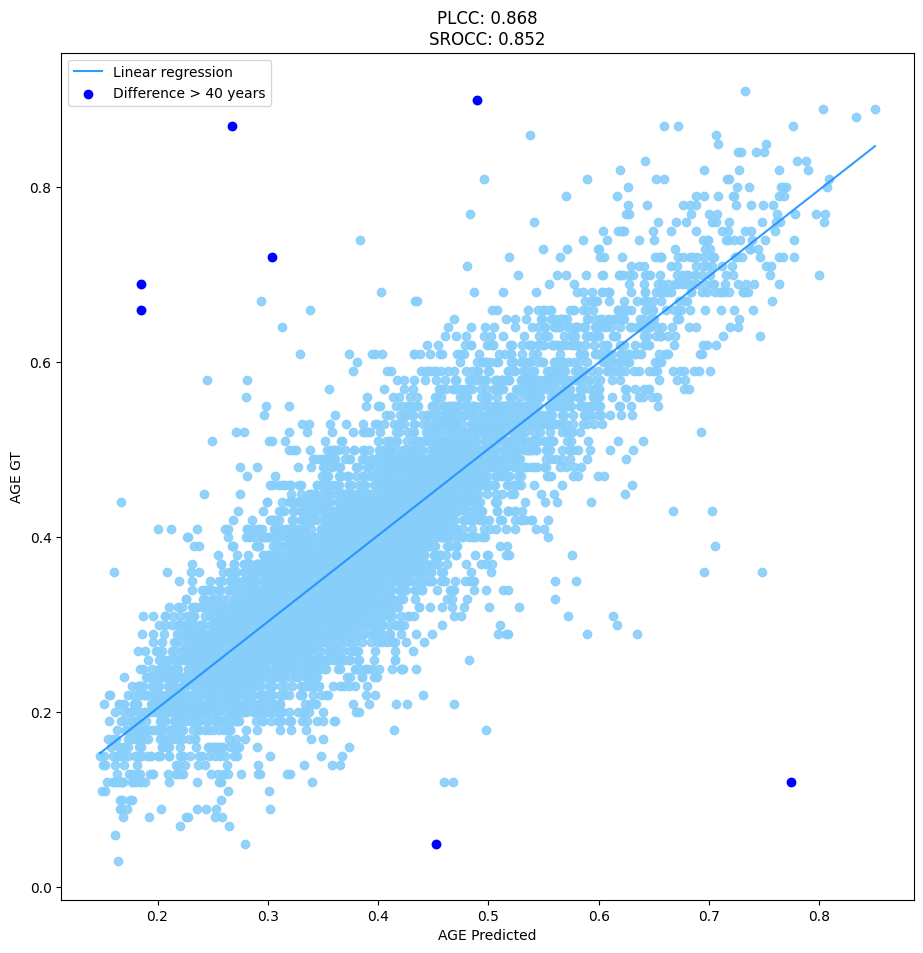

In [27]:
plt.figure(figsize=(11, 11), dpi=100)
plt.scatter(pr_labels, gt_labels, color="lightskyblue", alpha=0.90)
plt.xlabel("AGE Predicted")
plt.ylabel("AGE GT")
plt.title("PLCC: %.3f\nSROCC: %.3f" % (p, s))

# Calculate linear regression
slope, intercept = np.polyfit(pr_labels, gt_labels, 1)
x_values = np.linspace(min(pr_labels), max(pr_labels), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values ,color='dodgerblue', label="Linear regression", alpha=0.9)

# Highlight > 40 years
idxs = [i[0] for i in big_misclass]
if idxs:
    plt.scatter(pr_labels[idxs], gt_labels[idxs], color='blue', label=f'Difference > {int(misclassification*100)} years')
    plt.legend()

plt.show()

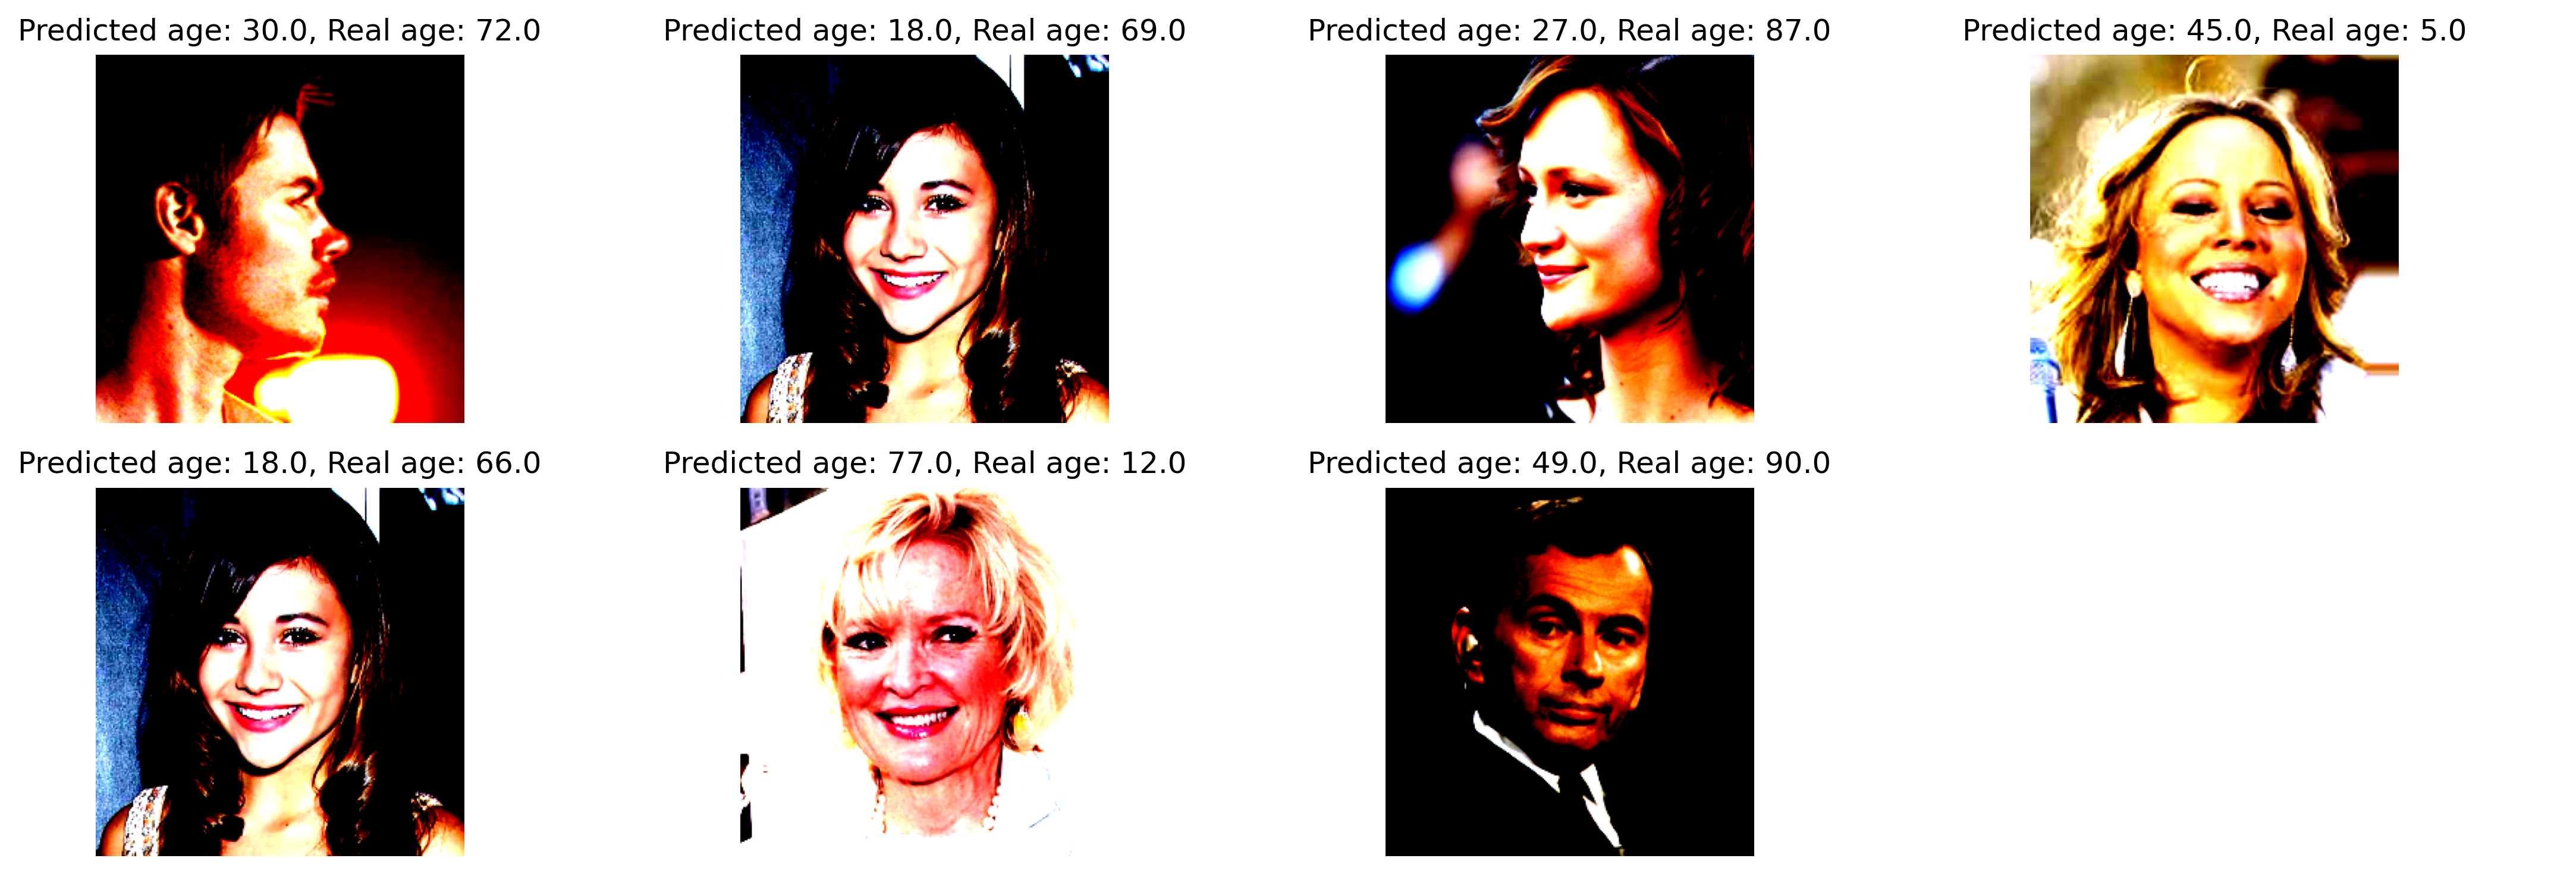

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(15, 5), dpi=300)
axes = axes.flatten()

num_plots = min(len(big_misclass), len(axes))

for i, misclass in enumerate(big_misclass[:num_plots]):
    if i < len(big_misclass):
      image_array = misclass[1].numpy().squeeze().transpose((1, 2, 0))
      ra = round(misclass[2]*100, 0)
      pa = round(misclass[3]*100, 0)

      ax = axes[i]  # Select the appropriate subplot
      ax.imshow(image_array)
      ax.axis('off')
      ax.set_title(f"Predicted age: {pa}, Real age: {ra}")

for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

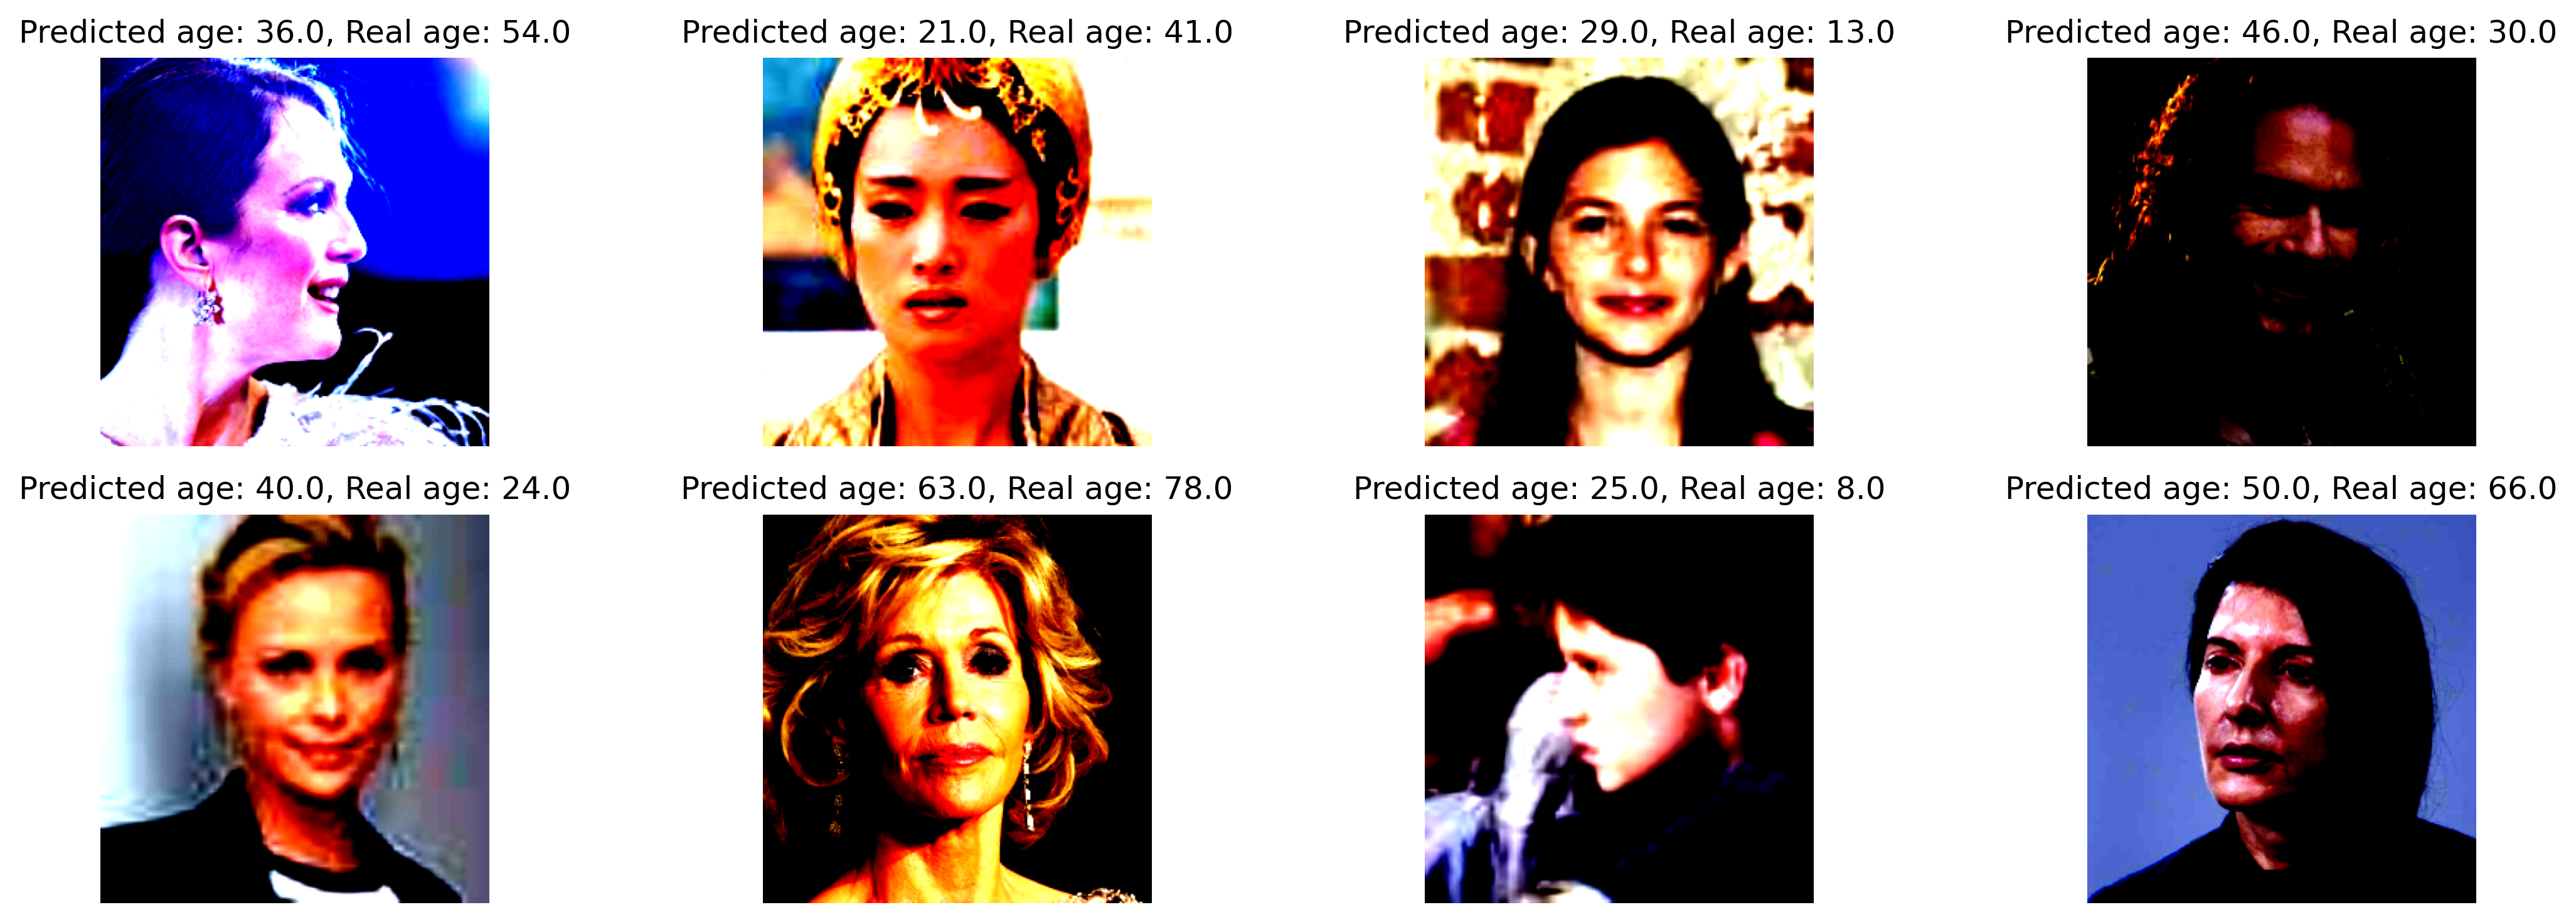

In [38]:
ok_misclass = random.sample(ok_misclass, 8)    # let's plot just 8 of them

fig, axes = plt.subplots(2, 4, figsize=(15, 5), dpi=300)
axes = axes.flatten()

num_plots = min(len(ok_misclass), len(axes))

for i, misclass in enumerate(ok_misclass[:num_plots]):
    if i < len(ok_misclass):
      image_array = misclass[1].numpy().squeeze().transpose((1, 2, 0))
      ra = round(misclass[2]*100, 0)
      pa = round(misclass[3]*100, 0)

      ax = axes[i]  # Select the appropriate subplot
      ax.imshow(image_array)
      ax.axis('off')
      ax.set_title(f"Predicted age: {pa}, Real age: {ra}")

for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**!ASSIGNMENT!**

*Transfer learning*
1. Finetune all the layers of the current network (mobilenet_v2).
2. Swap out the current model with a new one from [here](https://pytorch.org/vision/main/models.html) that is already trained on Imagenet. Then, fine-tune the network and compare how well it performs on the test-set compared to the current network (mobilenet_v2) using PLCC and SROCC metrics.

In [85]:
# Age distribution analysis

import time

train_ages = []
val_ages = []
test_ages = []

start_time = time.time()

for i, data in enumerate(trainloader):
    train_ages.append(round((data["age"]).numpy()[0]*100,1))

for i, data in enumerate(valloader):
    val_ages.append(round((data["age"]).numpy()[0]*100,1))

for i, data in enumerate(testloader):
    test_ages.append(round((data["age"]).numpy()[0]*100,1))

end_time = time.time()
print(f"Run in {end_time - start_time} seconds")

Run in 125.21289777755737 seconds


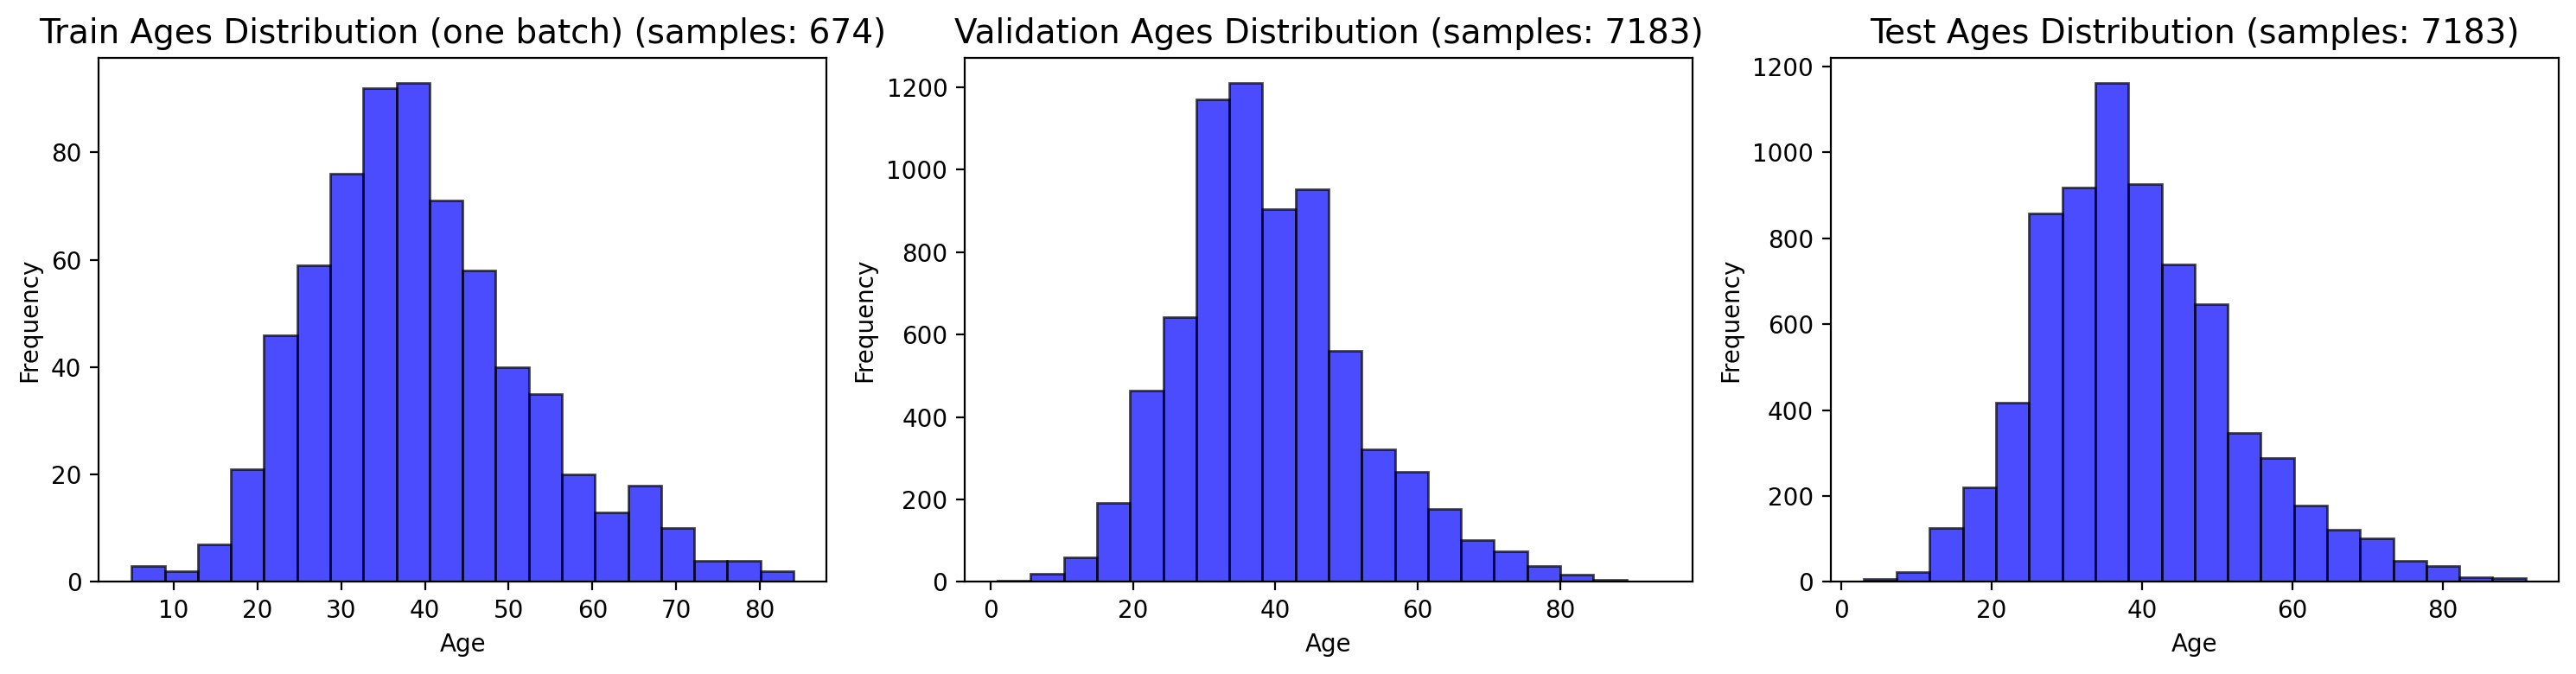

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=200)

# Plot histograms for train, val, and test sets
for ax, ages, title in zip(axs, [train_ages, val_ages, test_ages], ['Train Ages Distribution (one batch)', 'Validation Ages Distribution', 'Test Ages Distribution']):
    ax.hist(ages, bins=20, color="lightskyblue", alpha=0.90, edgecolor='black')
    ax.set_title(title+f" (samples: {len(ages)})", fontsize=14)
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')

plt.tight_layout()
#plt.savefig("unk.png")
plt.show()

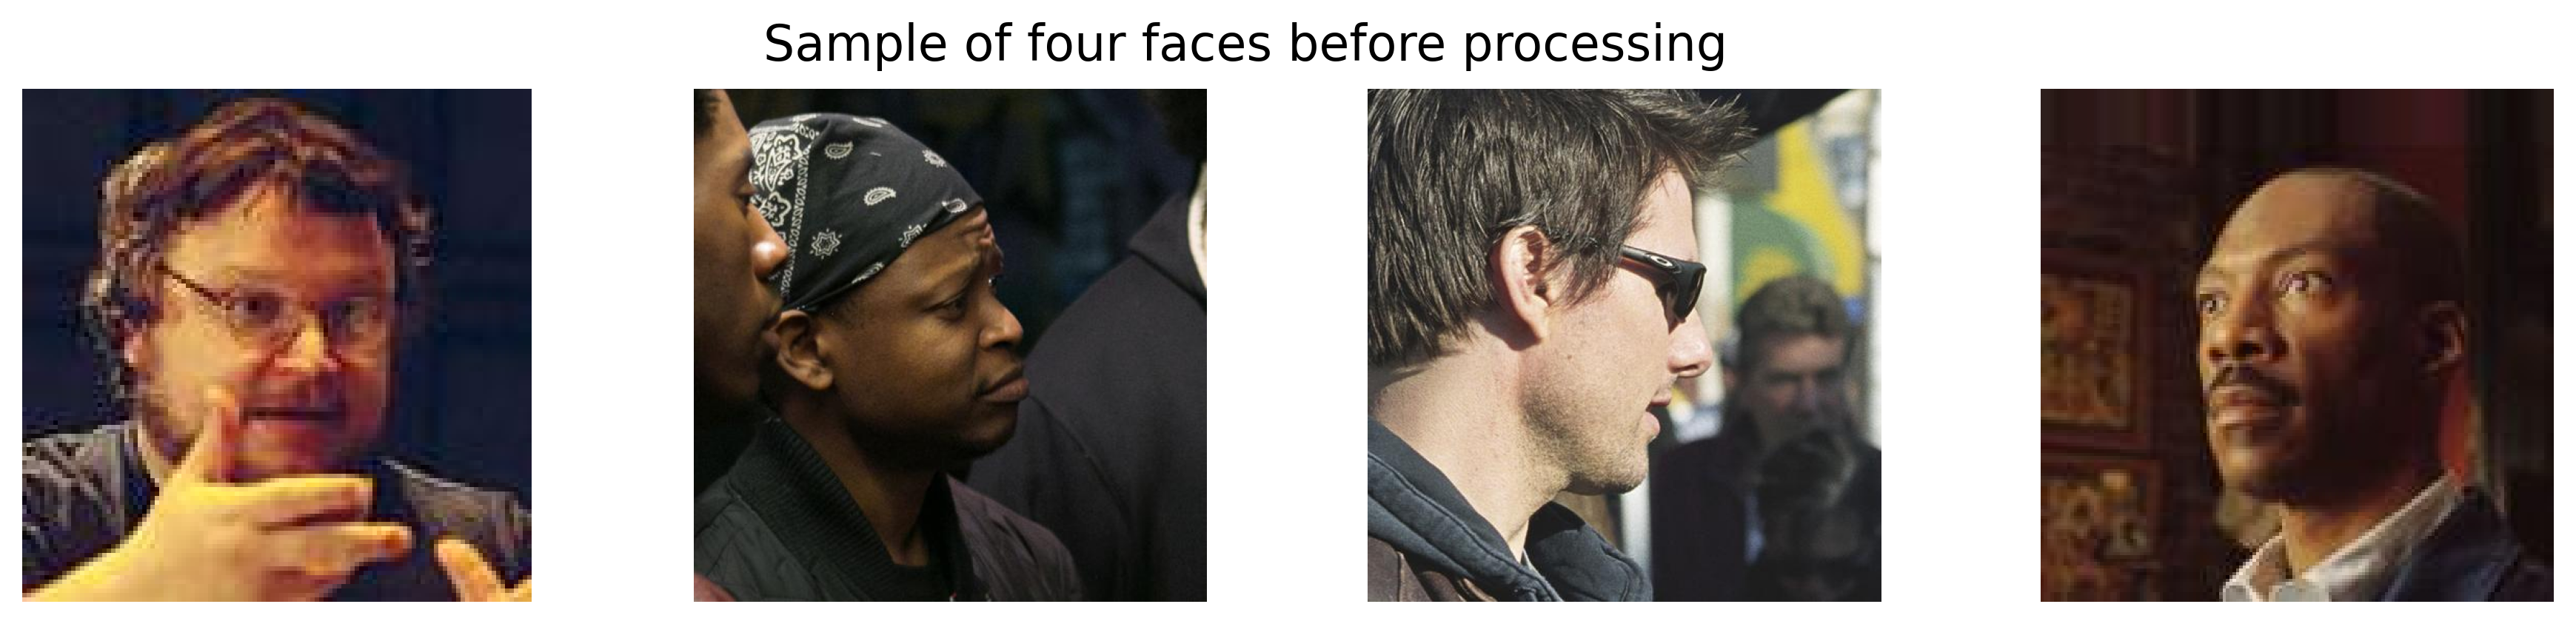

In [83]:
random_indices = random.sample(list(range(len(image_paths))), 4)
fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)

for i, idx in enumerate(random_indices):
    image = Image.open(image_paths[idx])
    axes[i].imshow(image)
    axes[i].axis('off')

plt.suptitle('Sample of four faces before processing', fontsize=16)
#plt.savefig("x.png", dpi=300)
plt.show()

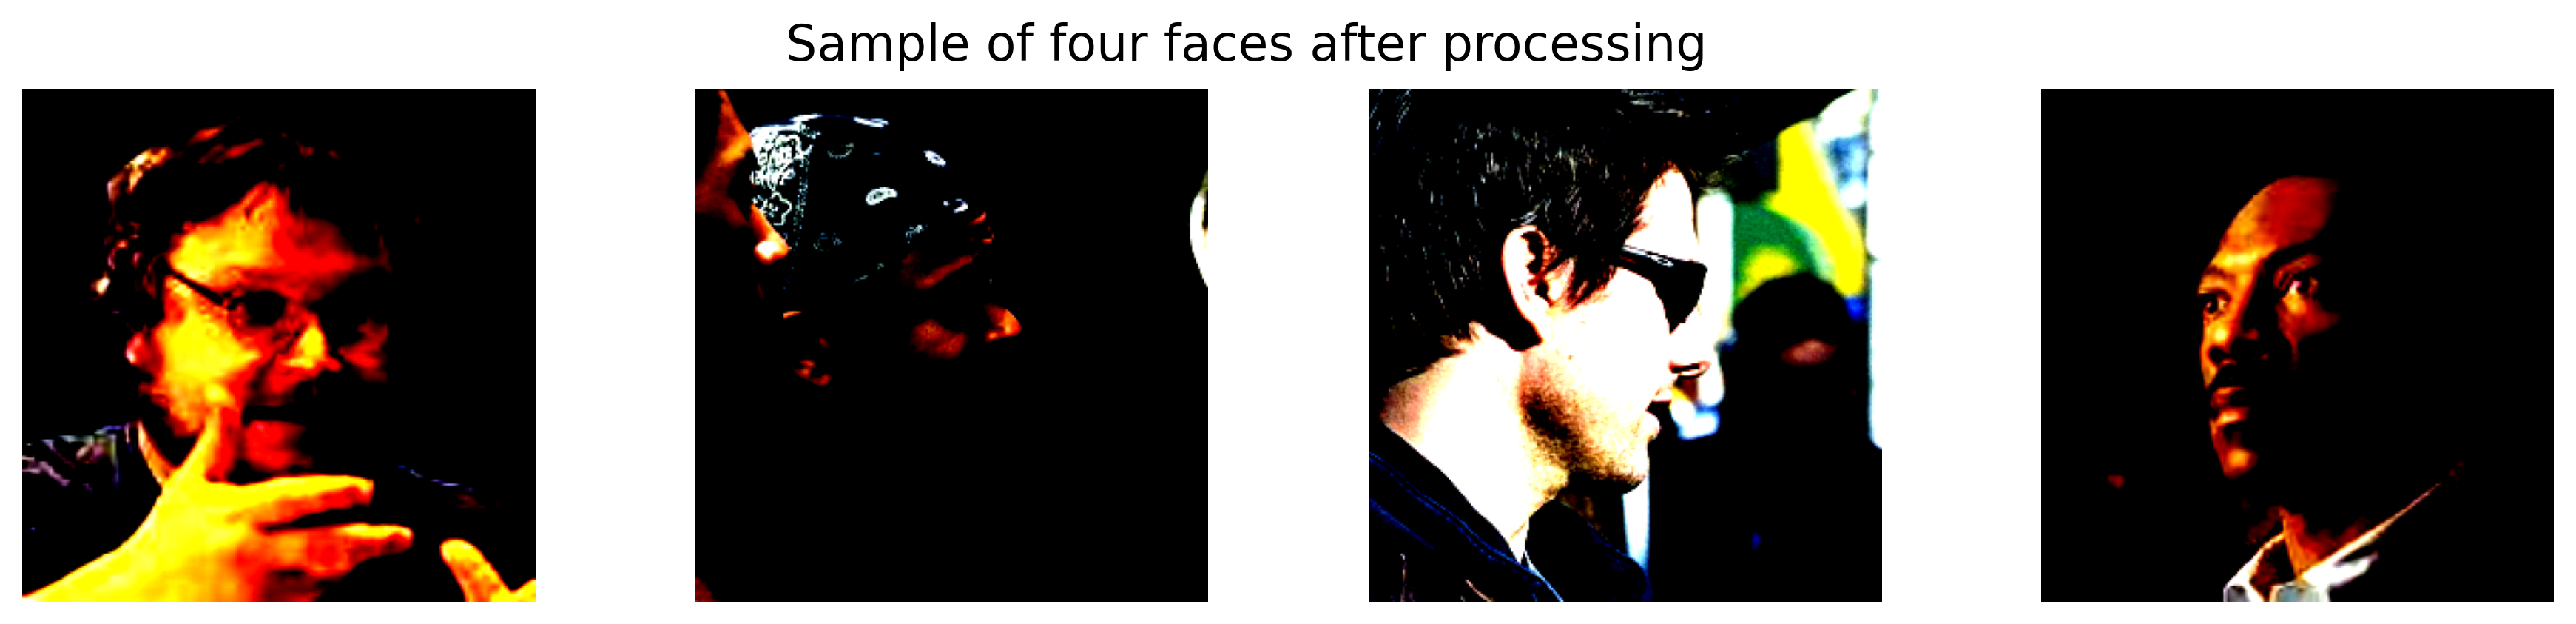

In [84]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)

for i, idx in enumerate(random_indices):
  image = Image.open(image_paths[idx])
  tensor_image = transform_val(image)
  tensor_image = tensor_image.unsqueeze(0)
  image_array = tensor_image.numpy().squeeze().transpose((1, 2, 0))
  axes[i].axis('off')
  axes[i].imshow(image_array)

plt.suptitle('Sample of four faces after processing', fontsize=16)
#plt.savefig("y.png", dpi=300)
plt.show()

Predicted age: 46.0


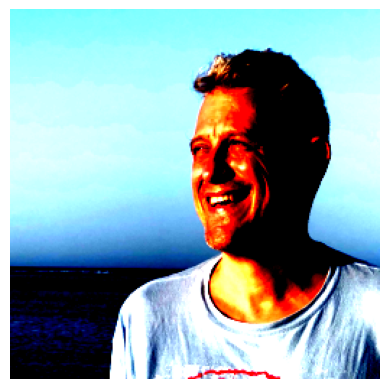

In [ ]:
# Random picture of davide's dad (he was 55)

from PIL import Image

image = Image.open("test.jpg")

# preprocessing
tensor_image = transform_val(image)
tensor_image = tensor_image.unsqueeze(0)

# what does the model get as input:
image_array = tensor_image.numpy().squeeze().transpose((1, 2, 0))
plt.axis('off')
plt.imshow(image_array)

# let's compute the prediction
tensor_image = tensor_image.to(device)
with torch.no_grad():
        print(f"Predicted age: {round(net(tensor_image).item()*100,0)}")